In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

/Users/Sensei/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
#########################################
# part (a)
#########################################

def sample(n=1000000,theta=np.array([[3],[1],[2]]),x1_par=(3,2),x2_par=(-1,2),sigma=np.sqrt(2)):
    X = np.column_stack([
            np.full(n,1),
            norm.rvs(loc=x1_par[0],scale=x1_par[1],size=n),
            norm.rvs(loc=x2_par[0],scale=x2_par[1],size=n)
        ])
    eps = norm.rvs(loc=0,scale=sigma,size=(n,1))
    
    return (X,X@theta + eps)

In [131]:
#########################################
# part (b)
#########################################

def normalize(a):
    return (a-a.mean())/a.std()

def h(X, theta):
    return X@theta

def J(X, Y, theta):
    return ((Y-X@theta)**2).mean()/2

def grad_J(X, Y, theta):
    return X.T@(X@theta - Y)/len(Y)

def stochastic_gradient_descent(X, Y, theta, batch_size=100, eta=0.001, stop_lim=0.000001, t_lim=100):
    
    theta_pts = [theta]
    losses = []
    
    train_X = X
    train_Y = Y
    
    t = 0
    
    # Convergence: 
    # Unlike gradient descent, for SGD, converge when the ratio of the change is small enough. Compute after
    # going over (atleast) 1000 samples.
    
    # this prevent the algorithm from taking too much time or if it's stuck without converging
    print(f"len_y = {len(Y)}")
    print(len(Y)//batch_size)
    while t < t_lim:
        
        n_samples = 0
        n_iters = 0
        loss_av = 0
        prev_loss_av = None
        
        for i in range(len(Y)//batch_size):
            X_batch = train_X[i*batch_size:(i+1)*batch_size]
            Y_batch = train_Y[i*batch_size:(i+1)*batch_size]
        
            loss_grad = grad_J(X_batch,Y_batch,theta_pts[-1])
            theta_n = theta_pts[-1] - eta*loss_grad
            n_samples += batch_size
            n_iters += 1
            loss_av += J(X_batch,Y_batch,theta_pts[-1])
            
            if (n_samples >= 1000):
                loss_av /= n_iters
                if prev_loss_av:
                    # compute ratio of loss of previous theta and current theta
                    # if it's less than the stop limit, then stop.
                    if (loss_av < prev_loss_av and abs(loss_av-prev_loss_av) < stop_lim) and loss_av < 1):
                        theta_pts.append(theta_n)
                        return (theta_pts,losses)
                    
                losses.append(loss_av)
                prev_loss_av = loss_av
                loss_av = 0
                n_samples = 0
                n_iters = 0
        
            theta_pts.append(theta_n)

        # random shuffle for the next epoch
        p = np.random.permutation(len(train_Y))
        train_X = train_X[p]
        train_Y = train_Y[p]
        
        t += 1
        
    if (t == t_lim):
        print("t_lim hit")
    
    return (theta_pts,losses)

In [132]:
#########################################
# part (d)
#########################################

def plot_paths(paths, elev=45, azim=60, save_file_name=None):
    
    fig = plt.figure(figsize=(5,5), dpi=150)
    ax = fig.add_axes([0,0,1,1], projection='3d')
    ax.view_init(elev=elev, azim=azim)
    #surf = ax.plot_surface(t0_space, t1_space, loss_space, cmap='viridis', edgecolor=None, alpha=alpha)
    #surf.set_facecolor((0,0,0,0))
    ax.set_title('Paths taken by gradient descent for varying values of b')
    ax.set_xlabel('theta_0')
    ax.set_ylabel('theta_1')
    ax.set_zlabel('theta_2')
    
    for (i,path) in enumerate(paths):
        path = path[::20]
        desc_x, desc_y, desc_z = np.stack(path,axis=0).reshape((len(path),3)).T
        ax.plot(desc_x, desc_y, desc_z, marker='.', alpha=0.5, label=f'b={10**(i*2)}')
        
    if save_file_name:
        fig.savefig(save_file_name, bbox_inches='tight')
    
    ax.legend()

In [133]:
# [StopConvert]

In [134]:
X, Y = sample()

In [135]:
from timeit import default_timer as timer

paths = []
losses = []
for (i,stop_lim) in [
    (1,0.001),
    (100,0.001),
    (10000,0.001),
    (1000000,0.001)]:
    
    start_time = timer()
    (path,loss_av) = stochastic_gradient_descent(X, Y, np.array([[0],[0],[0]]), batch_size=i, stop_lim=stop_lim)
    end_time = timer()
    paths.append(path)
    losses.append(loss_av)
    print(f"b={i} converged in {len(path)-1} iterations and {end_time-start_time} s")

thetas = np.stack([path[-1] for path in paths])

len_y = 1000000
1000000
b=1 converged in 16000 iterations and 0.4387265209998077 s
len_y = 1000000
10000
b=100 converged in 3660 iterations and 0.11310674400010612 s
len_y = 1000000
100
b=10000 converged in 299 iterations and 0.325332346000323 s
len_y = 1000000
1
t_lim hit
b=1000000 converged in 100 iterations and 13.534245582999574 s


In [137]:
print(thetas)

[[[2.94760707]
  [0.98940211]
  [1.97177452]]

 [[1.97208483]
  [1.22687957]
  [1.92043883]]

 [[0.43331024]
  [1.33825257]
  [1.18150509]]

 [[0.2443887 ]
  [0.916903  ]
  [0.46391701]]]


0.9737523719372935


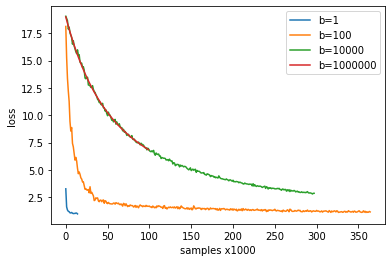

In [136]:
for (i,loss_av) in enumerate(losses):
    plt.plot(loss_av,label=f'b={10**(i*2)}')
    
plt.legend()
plt.xlabel('samples x1000')
plt.ylabel('loss')
#plt.savefig('plots/loss.png', dpi=150)
print(losses[0][-1])

In [115]:
test_data = pd.read_csv('../data/q2/X.csv')
X = np.column_stack([np.full(len(test_data),1),test_data['X_1'].to_numpy(),test_data['X_2'].to_numpy()])
Y = test_data['Y'].to_numpy().reshape(-1,1)

vector_J = np.vectorize(J,signature="(m,3),(m,1),(3,1)->()")
err = vector_J(X,Y,thetas)
err_def = J(X,Y,np.array([[3],[1],[2]]))

In [116]:
err,err_def

(array([  1.05113074,   1.21074866,   1.24643567, 121.00565549]), 0.9829469215)

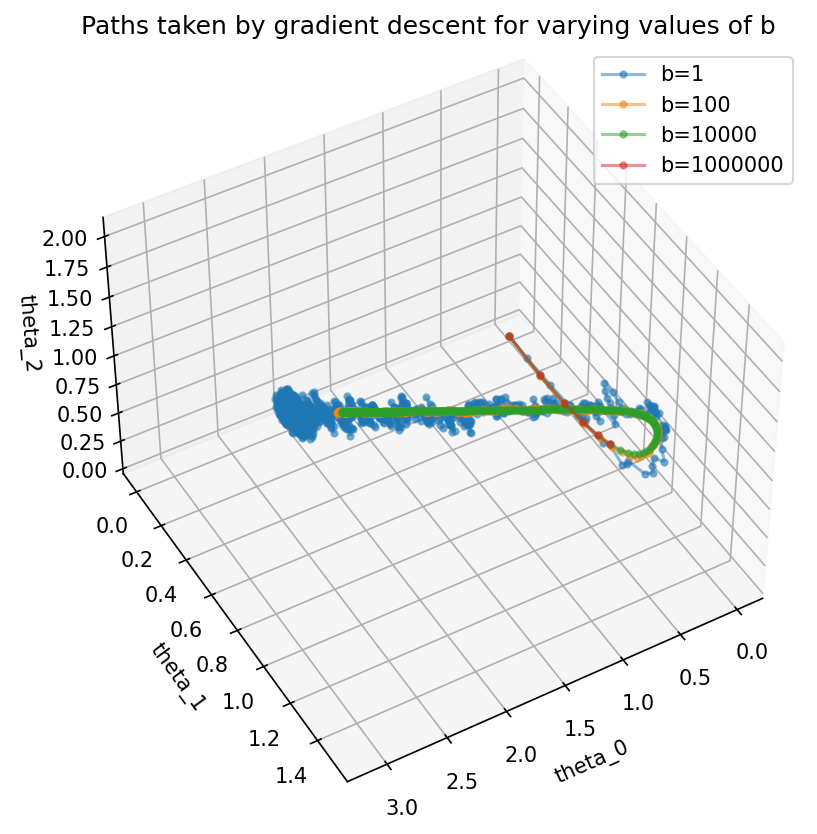

In [112]:
plot_paths(paths, save_file_name='plots/d_paths.png')